# Evolution of CRO disclosure over time

In [1]:
import sys
import math
from datetime import date
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sys.path.append('../..')
from data import constants

# Setup seaborn
sns.set_theme(style="ticks", rc={'text.usetex' : True})
# sns.set_context("paper")

# Read main file
df = pd.read_pickle("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Data/stoxx_inference/Firm_AnnualReport_Paragraphs_with_actual_back.pkl")
df = df.set_index(["id"])
assert df.index.is_unique, "Index is not unique. Check the data!"

# Read master for scaling
df_master = pd.read_csv("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Data/stoxx_inference/Firm_AnnualReport.csv")
df_reports_count = df_master.groupby('year')['is_inferred'].sum()



## Config

In [2]:
category_labels = constants.cro_category_labels
category_codes = constants.cro_category_codes
colors = sns.color_palette("GnBu", len(category_codes))
levelize_year = 2015

## Evolution over the years

Shows the level of *average number of predicted CRO's per report* (ACROR) over time, in 2015 *levels* (i.e. 2015 scaled to 1).

    1. divide by amount of reports in each year
    2. then report the levels by dividing by 2015 values
    
Why 2015? Paris and simply because it of missing values otherwise...

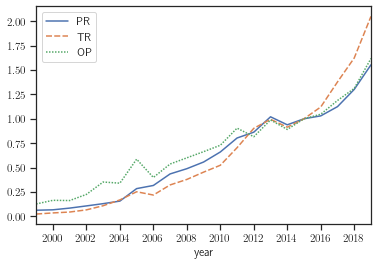

In [17]:
# Create yearly bins for each category
df_years = df.groupby('year')[[f"{c}_predicted" for c in category_codes]].sum().T

# 1. Divide by number of reports in each year
df_years = df_years / df_reports_count

# 2. Divide by the first column to get levels
level_column = df_years[levelize_year]
df_years = df_years.T / level_column
# df_years = df_years.T
df_years.rename(columns={'PR_predicted': 'PR', 'TR_predicted': 'TR', 'OP_predicted': 'OP'}, inplace=True)

# Plot
ax = sns.lineplot(data=df_years)
plt.legend(loc='upper left')
plt.xlim()
plt.xlim(min(df_years.index), max(df_years.index))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
fig.savefig('/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Thesis/figures/levels_acror_years.pdf', format='pdf', bbox_inches='tight')

## Evolution by country

In [18]:
index_id = 'country'
results = {}

In [19]:
pd.pivot_table(df_master, values="is_inferred", index=[index_id], columns=['year'], aggfunc=np.sum, fill_value = 0)

year,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
country,,,,,,,,,,,,,,,,,,,,,
be,0,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ch,0,0,1,1,1,3,4,4,4,5,...,6,6,6,6,6,6,6,6,6,6
de,4,4,5,5,6,6,6,6,6,6,...,7,7,7,7,7,7,7,7,7,7
dk,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
es,1,1,1,2,2,1,2,2,2,3,...,3,3,3,3,3,3,3,3,3,3
fr,3,4,4,5,6,6,6,6,7,8,...,10,9,10,10,10,10,10,10,10,10
gb,3,5,6,6,6,9,12,12,14,15,...,15,17,16,16,16,16,17,16,17,17
it,0,0,0,0,0,0,0,0,1,1,...,1,2,2,2,2,2,2,2,2,2
nl,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2


In [22]:
reports_count = pd.pivot_table(df_master, values="is_inferred", index=['country'], columns=['year'], aggfunc=np.sum, fill_value = 0)

year
1999    0
2000    0
2001    1
2002    1
2003    1
2004    3
2005    4
2006    4
2007    4
2008    5
2009    6
2010    6
2011    6
2012    6
2013    6
2014    6
2015    6
2016    6
2017    6
2018    6
2019    6
Name: ch, dtype: int64

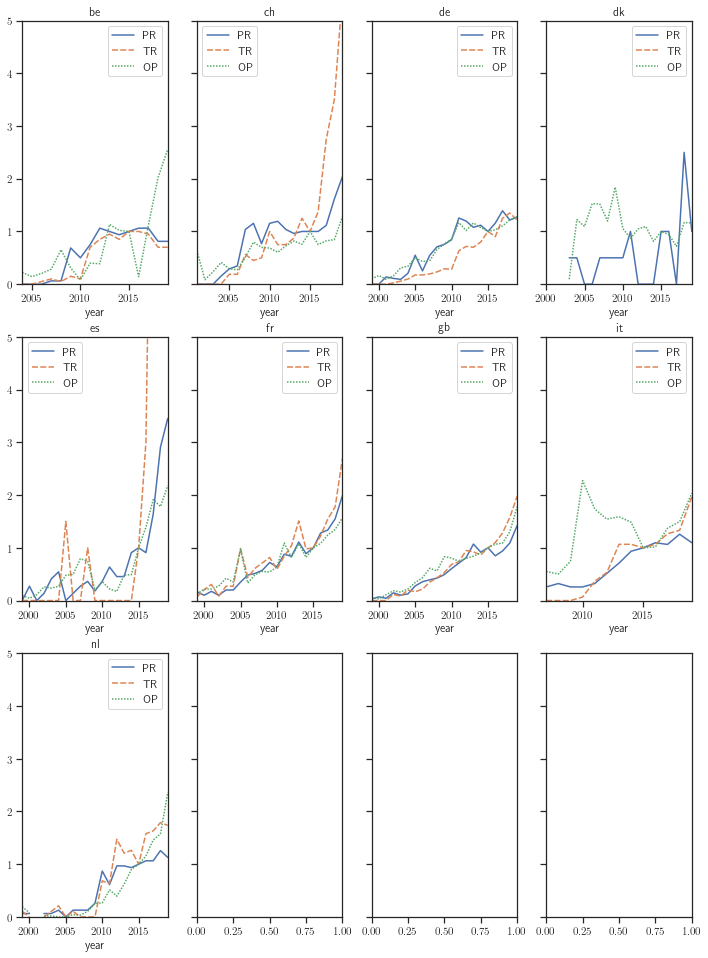

In [41]:
def plot_grid_by_group(groups, group_column):
    reports_count = pd.pivot_table(df_master, values="is_inferred", index=[group_column], columns=['year'], aggfunc=np.sum, fill_value = 0)
    
    rows = math.ceil(len(groups) / 4)
    fig, axs = plt.subplots(rows, 4, 
                            figsize=(12, 15 if rows > 1 else 5), 
                            sharex=False, 
                            sharey=True, 
                            # constrained_layout=True
                           )

    axs = axs.ravel()
    for idx, c in enumerate(groups):
        ax = axs[idx]
        
        df_group = df.query(f"{group_column} == @c")
        
        # Create yearly bins for each category
        df_years = df_group.groupby('year')[[f"{c}_predicted" for c in category_codes]].sum().T
        
        # 1. Divide by number of reports in each year
        df_years = df_years / reports_count.loc[c]

        # 2. Divide by the first column to get levels
        level_column = df_years[levelize_year]
        df_years = df_years.T / level_column
        # df_years = df_years.T
        
        df_years.rename(columns={'PR_predicted': 'PR', 'TR_predicted': 'TR', 'OP_predicted': 'OP'}, inplace=True)

        sns.lineplot(ax=ax, data=df_years)
        ax.set_ylim(0, 5)
        ax.set_xlim(min(df_group.year), max(df_group.year))
        ax.title.set_text(c)

    fig.subplots_adjust(bottom=0.05 if rows > 2 else 0.25)
    return fig

all_countries = sorted(df_master.country.unique())
all_countries_fig = plot_grid_by_group(all_countries, 'country')
# all_countries_fig.savefig('/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Thesis/figures/levels_acror_countries.pdf', format='pdf', bbox_inches='tight')

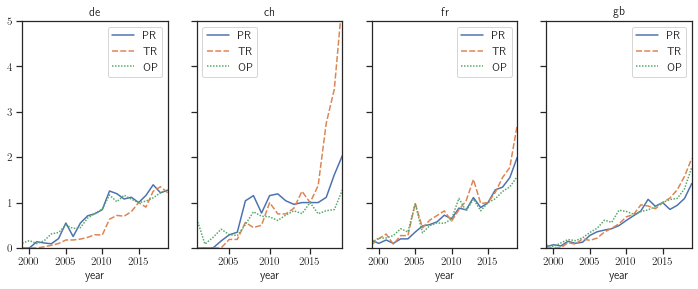

In [42]:
selected_countries_fig = plot_grid_by_group(["de", "ch", "fr", "gb"], 'country')

## Industry

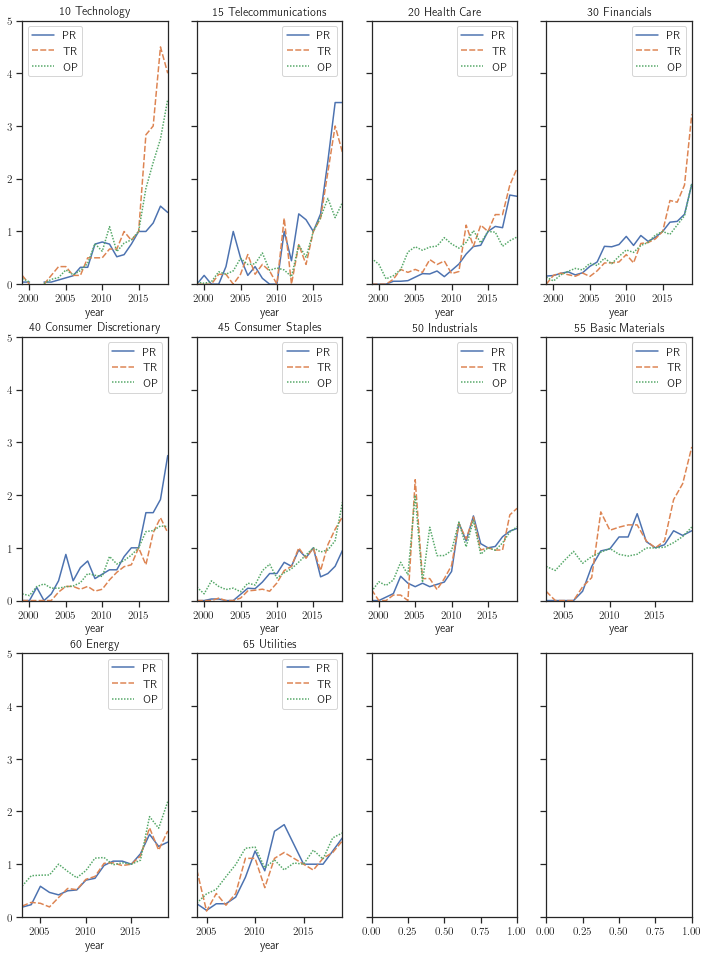

In [43]:
all_industries = sorted(df_master.icb_industry.unique())
all_inudustries_fig = plot_grid_by_group(all_industries, 'icb_industry')